# Visualisation du corpus

In [1]:
from src.corpus_visualisation import *

# Téléchargement des ressources NLTK nécessaires
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

## Chargement des données

In [2]:
# Chargement des données
input_file = "articles_with_clusters.pkl"  # Adaptez ce chemin
df = load_processed_data(input_file)
df = prepare_texts(df)


Données chargées avec succès. Shape: (23702, 13)


## Visualisation des termes fréquents

Extraction des comptes de termes...
Nombre de termes extraits: 7673


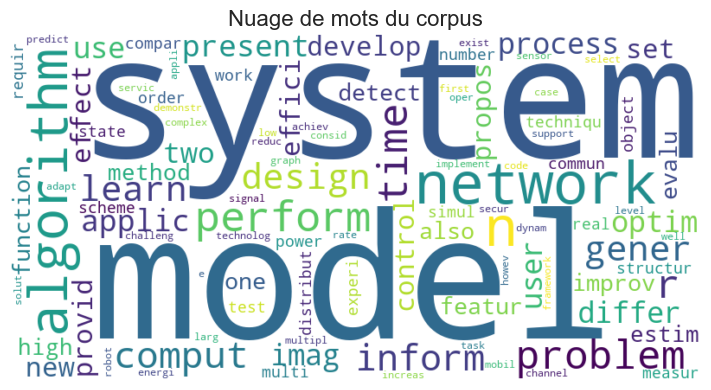

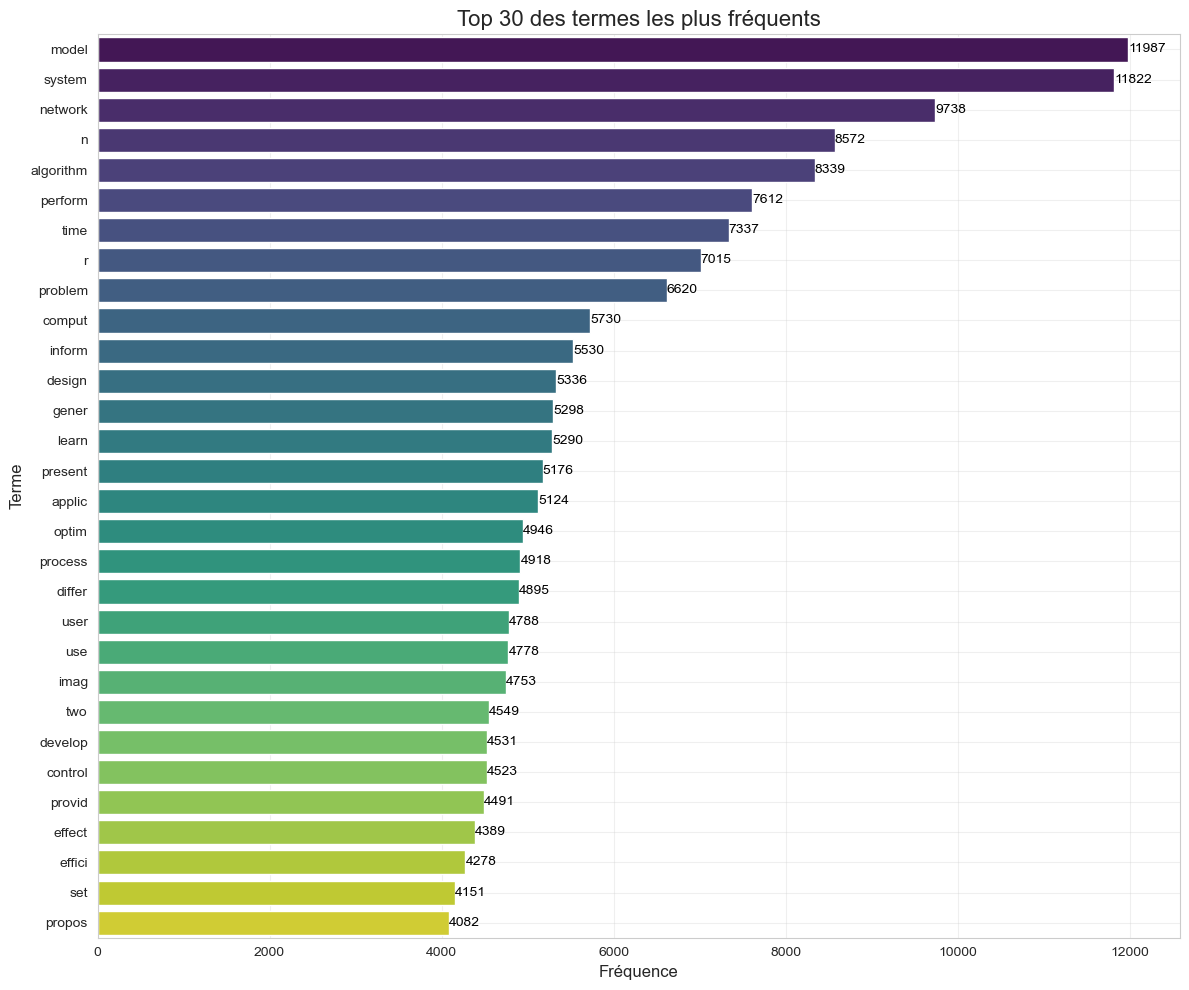

In [3]:
# Visualisation des termes fréquents
term_viz = TermVisualizer(df)
term_counts = term_viz.extract_term_counts(min_df=5, max_df=0.95)
term_viz.create_wordcloud(max_words=100)
term_viz.plot_top_terms(n_terms=30)
interactive_hist = term_viz.create_interactive_term_histogram(n_terms=50)
interactive_hist 

## Visualisation des co-occurrences

Construction de la matrice de co-occurrences...


Calcul des co-occurrences: 100%|██████████| 23702/23702 [00:00<00:00, 183877.88it/s]


Matrice de co-occurrences construite: (35, 35)
Extraction des collocations...
Nombre de collocations extraites: 30


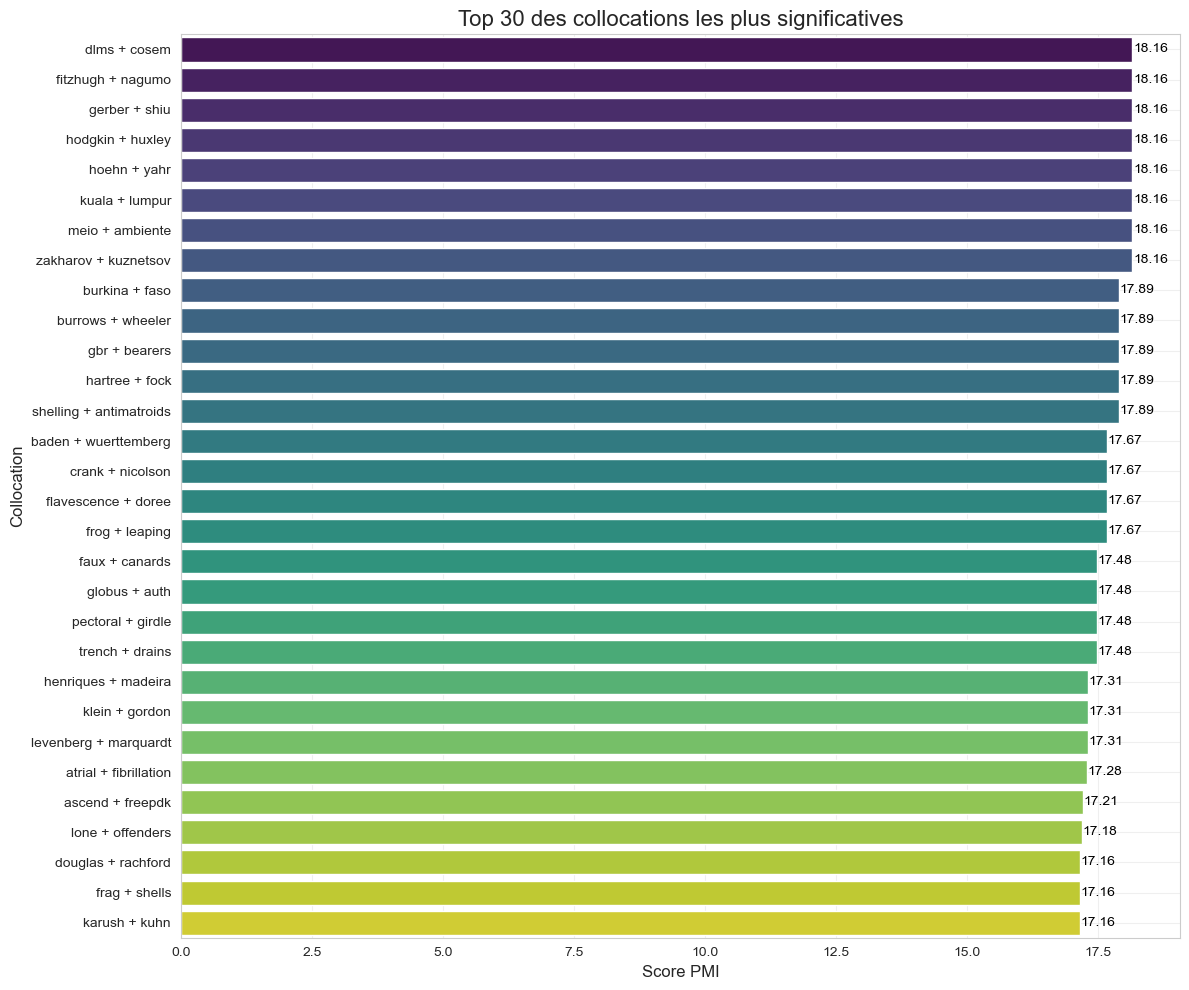

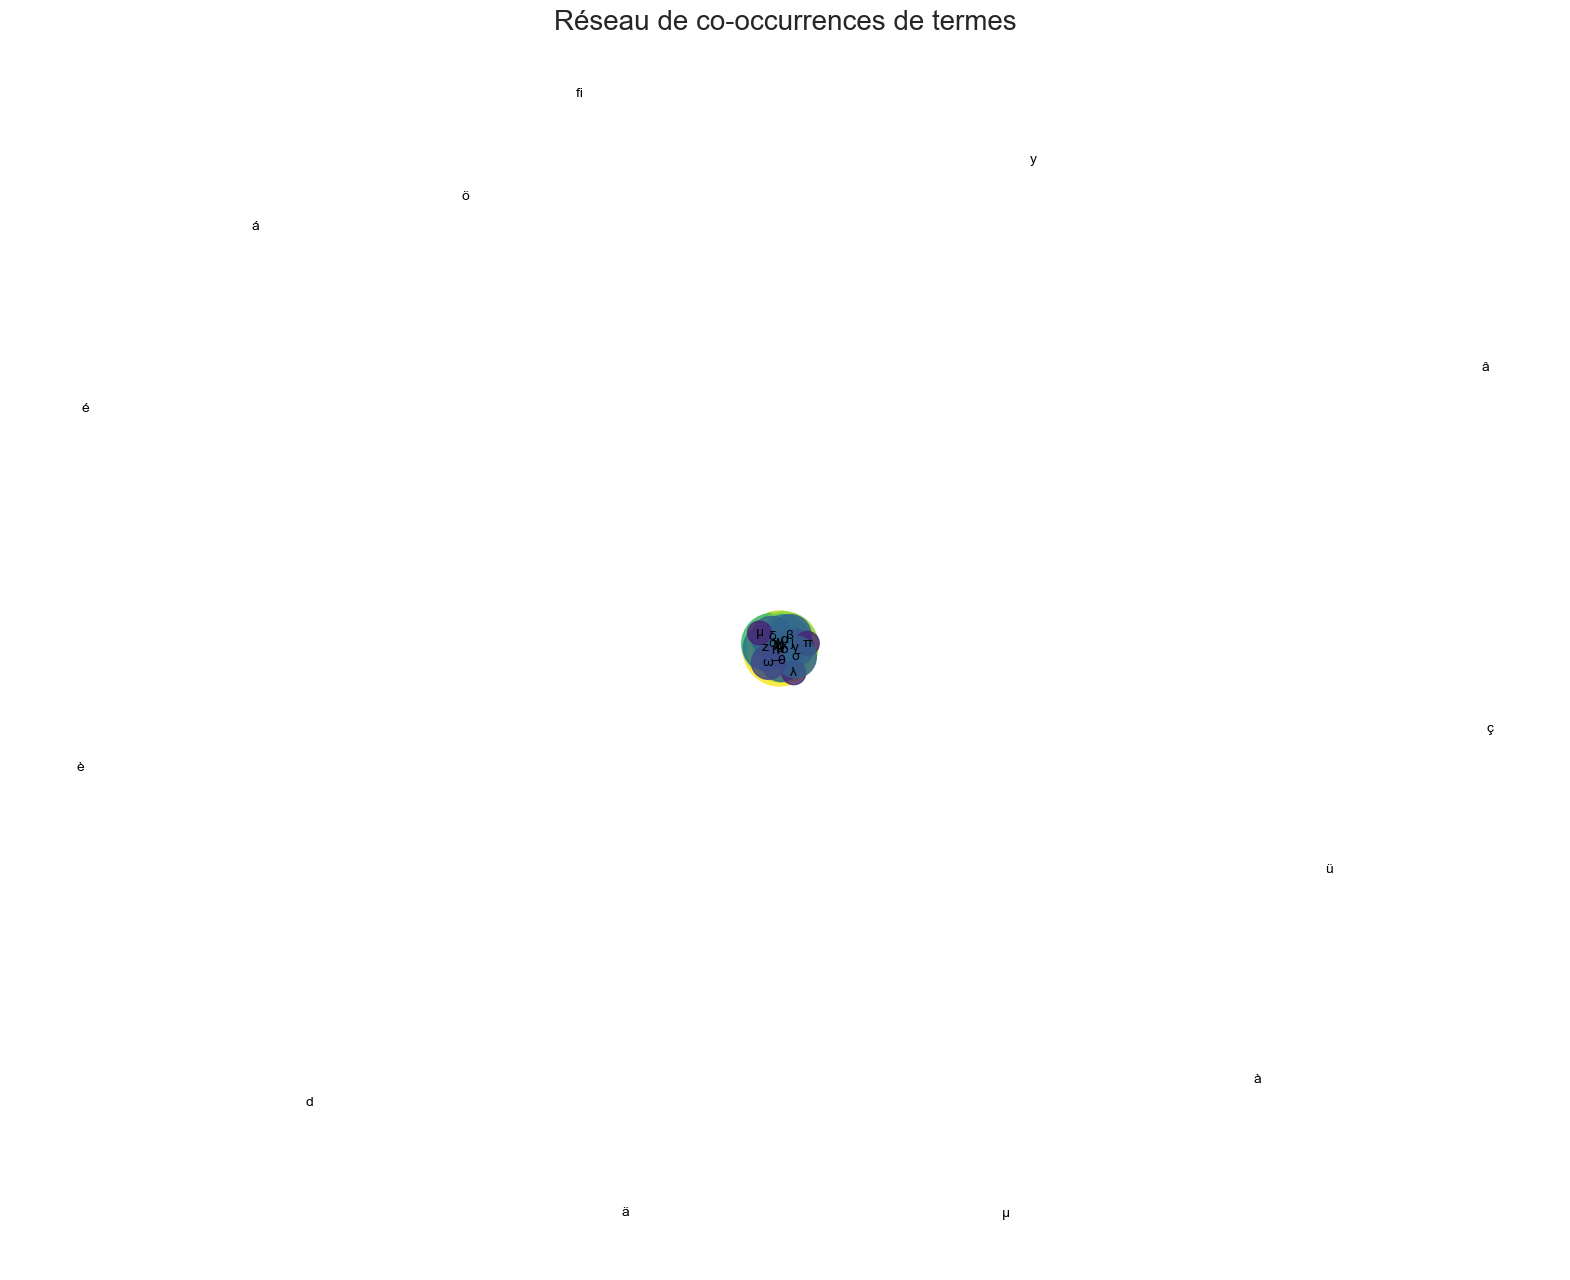

<Figure size 640x480 with 0 Axes>

In [4]:
# Visualisation des co-occurrences
cooc_viz = CooccurrenceVisualizer(df)
cooc_viz.build_cooccurrence_matrix(window_size=5, min_df=10, max_df=0.9, max_features=500)
cooc_viz.plot_collocations(n_collocations=30)
cooc_viz.plot_cooccurrence_network(n_edges=100)
cooc_network = cooc_viz.create_interactive_cooccurrence_network(n_nodes=30, n_edges=50)
cooc_network  # Pour afficher dans Jupyter


## Visualisation des thématiques LDA

Entraînement du modèle LDA...


Prétraitement des textes: 100%|██████████| 23702/23702 [00:05<00:00, 4137.17it/s]


Modèle LDA entraîné avec 10 thématiques
Thématiques extraites par le modèle LDA (10 mots par thématique):

Thématique #0:
control (0.0303), system (0.0244), systems (0.0148), model (0.0140), robot (0.0102), simulation (0.0084), time (0.0082), motion (0.0074), tracking (0.0073), state (0.0066)

Thématique #1:
energy (0.0152), networks (0.0147), performance (0.0132), power (0.0123), channel (0.0109), wireless (0.0108), network (0.0105), scheme (0.0089), rate (0.0074), nodes (0.0063)

Thématique #2:
algorithm (0.0221), problem (0.0169), time (0.0118), algorithms (0.0113), model (0.0095), optimization (0.0090), problems (0.0064), two (0.0061), methods (0.0060), search (0.0058)

Thématique #3:
k (0.0133), graph (0.0119), graphs (0.0081), linear (0.0076), g (0.0074), problem (0.0070), set (0.0069), function (0.0068), two (0.0065), functions (0.0065)

Thématique #4:
social (0.0121), learning (0.0092), information (0.0084), online (0.0062), use (0.0060), students (0.0059), health (0.0052), med

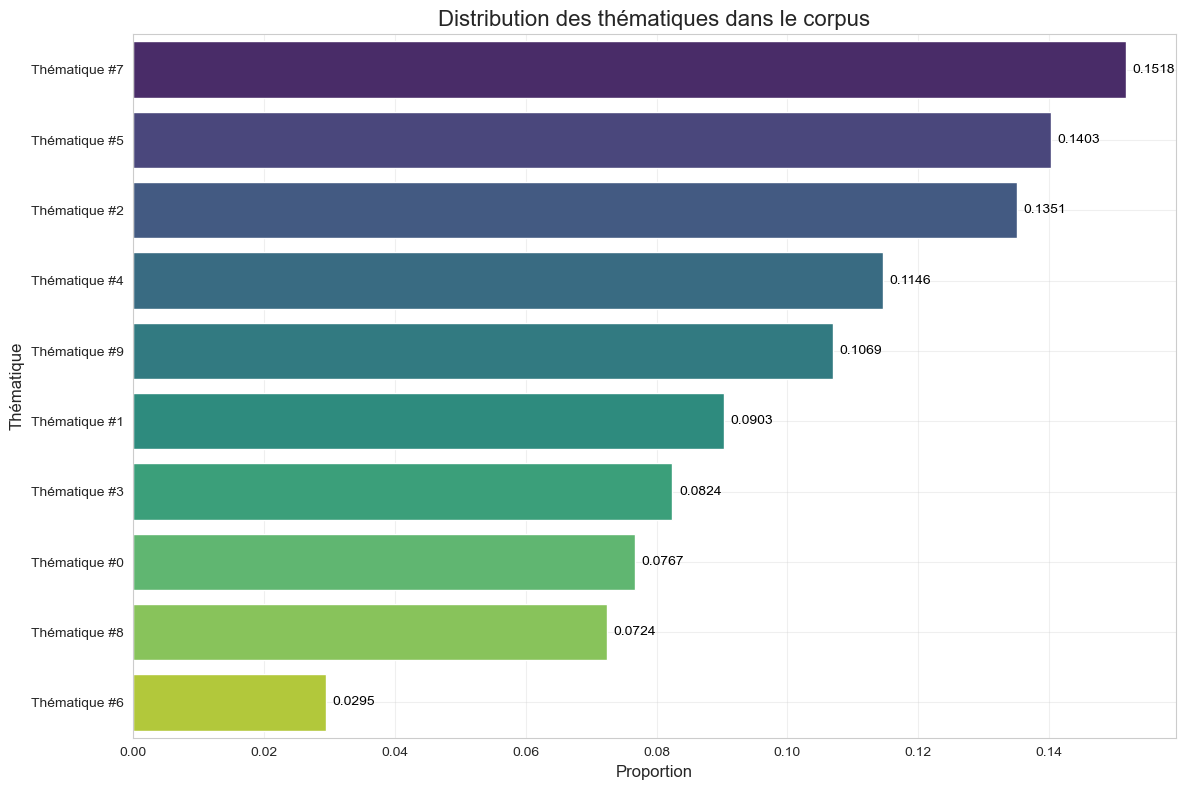

<Figure size 640x480 with 0 Axes>

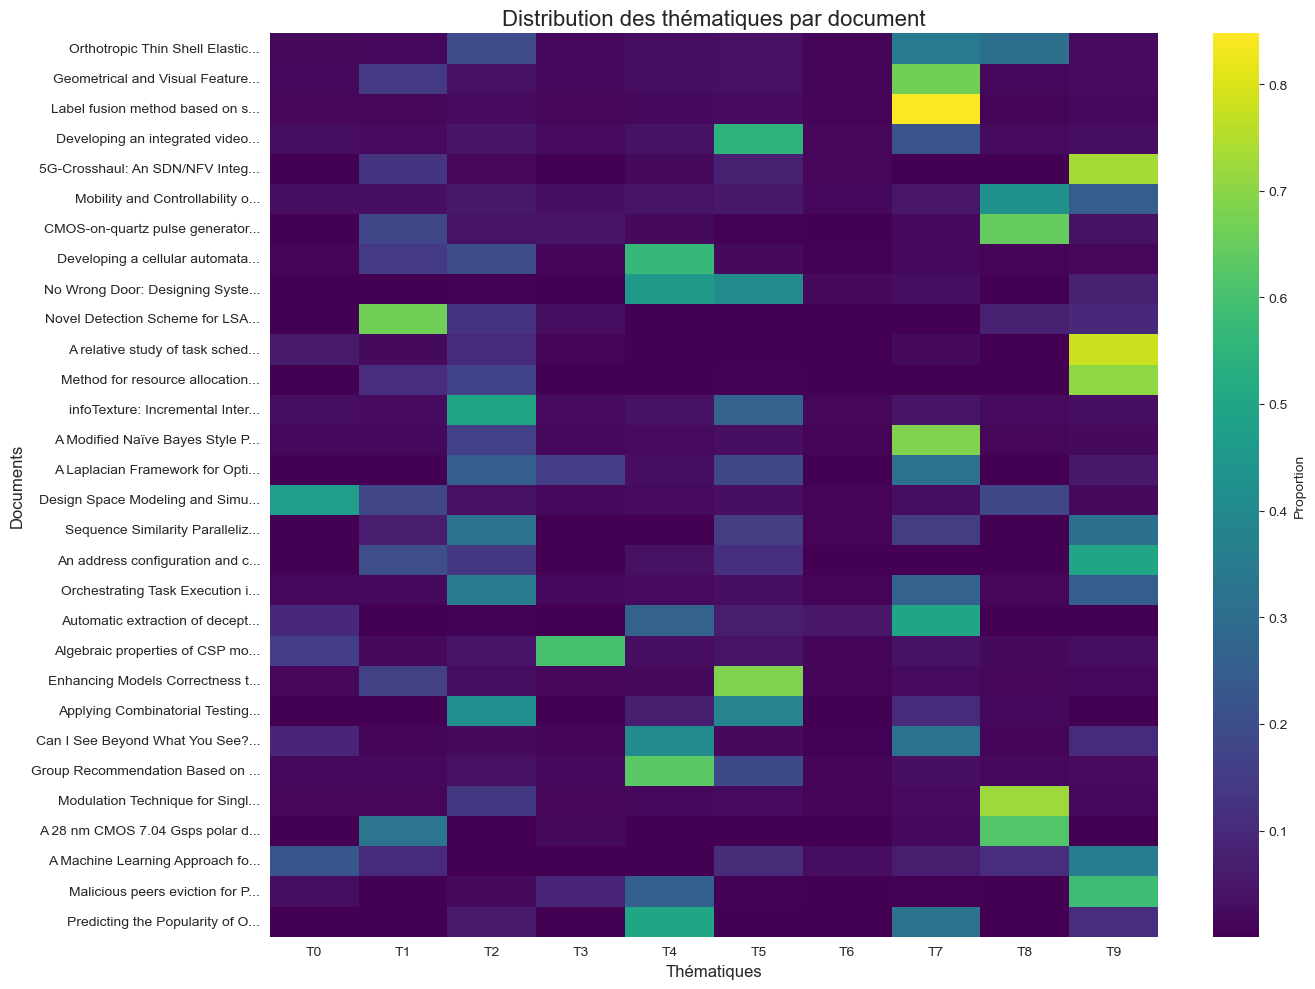

<Figure size 640x480 with 0 Axes>

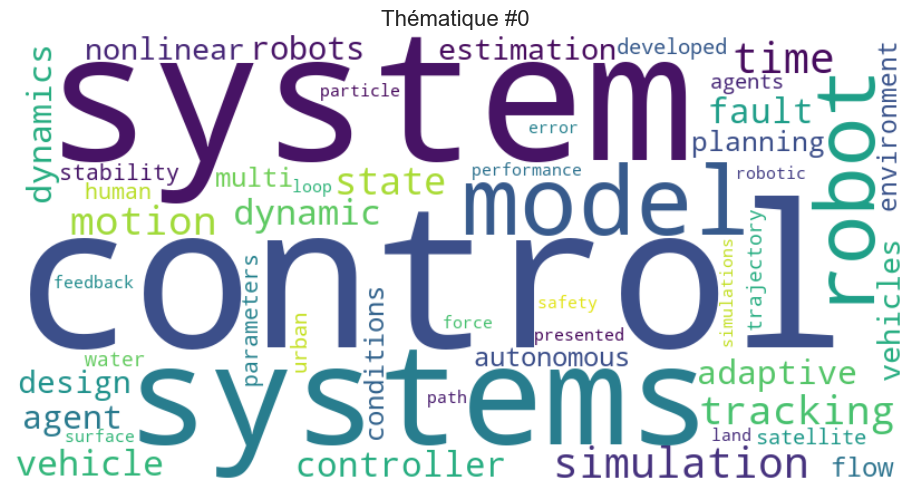

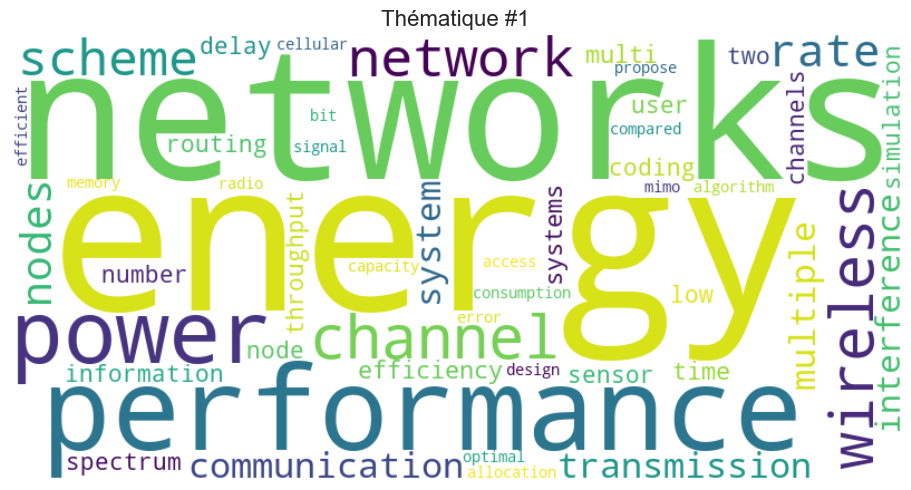

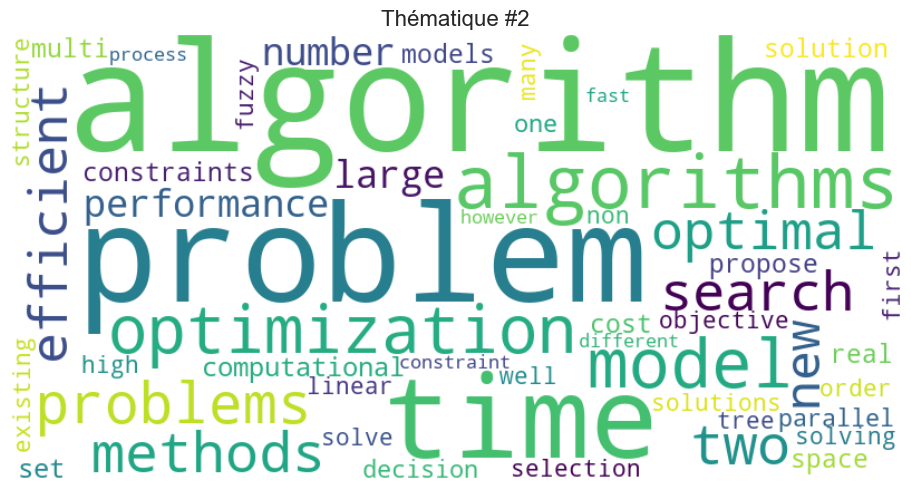

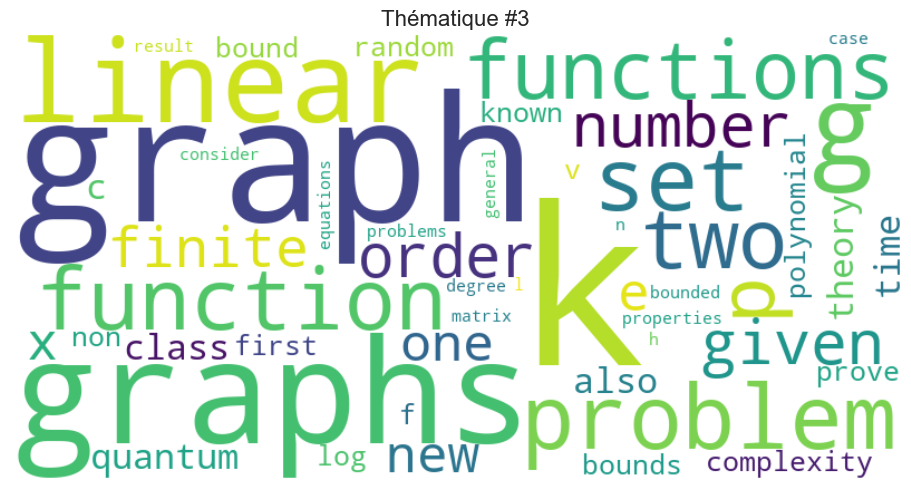

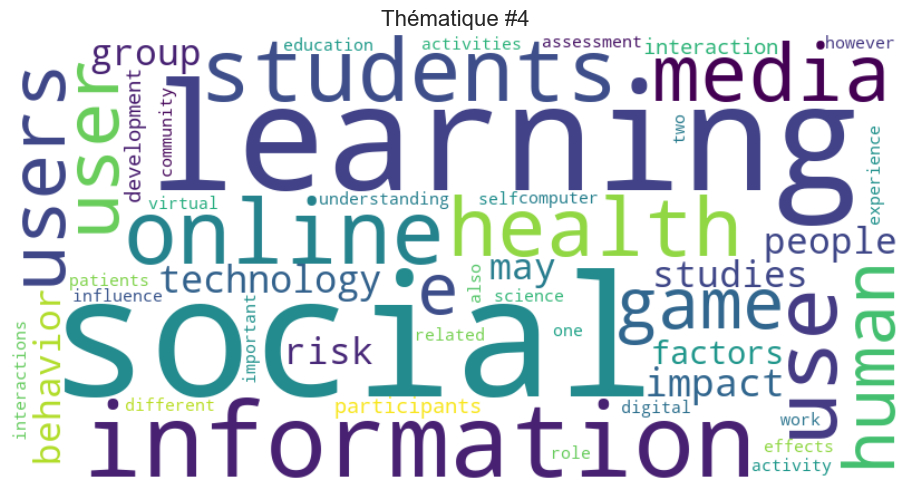

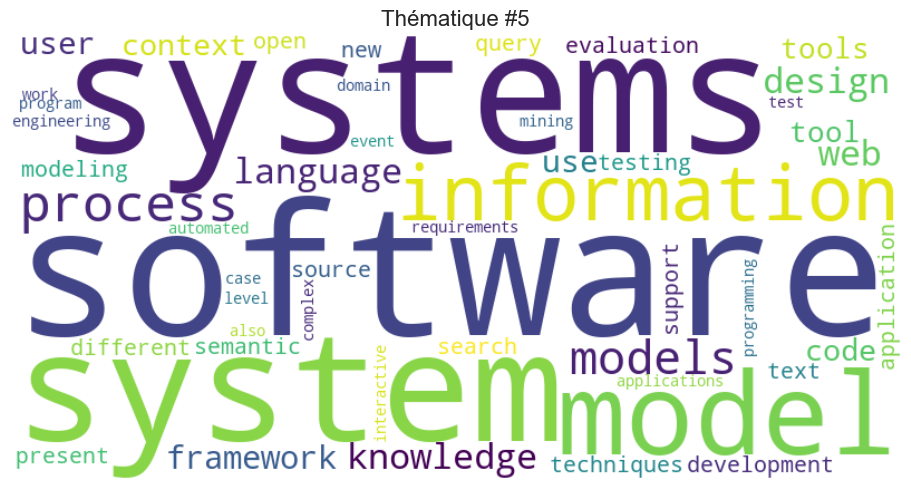

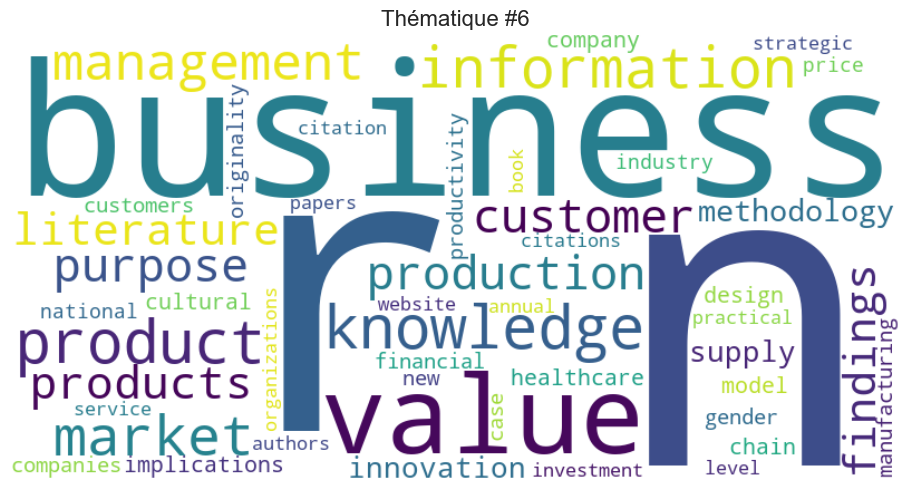

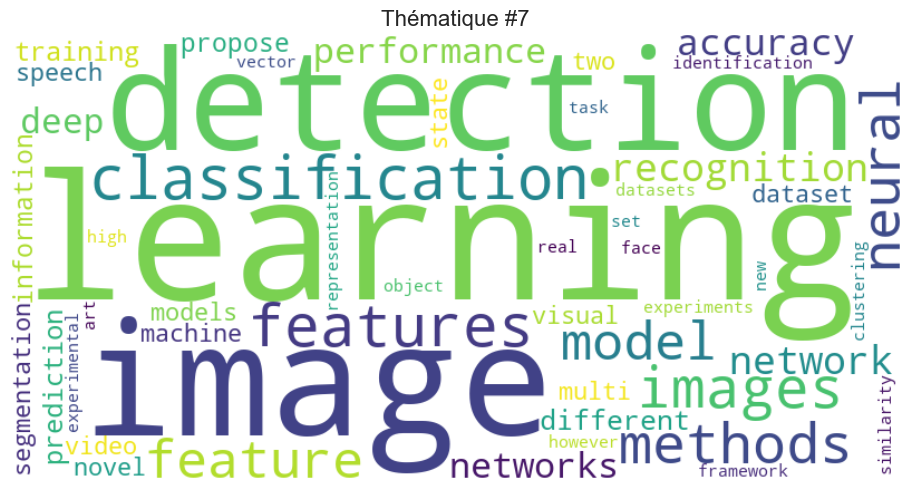

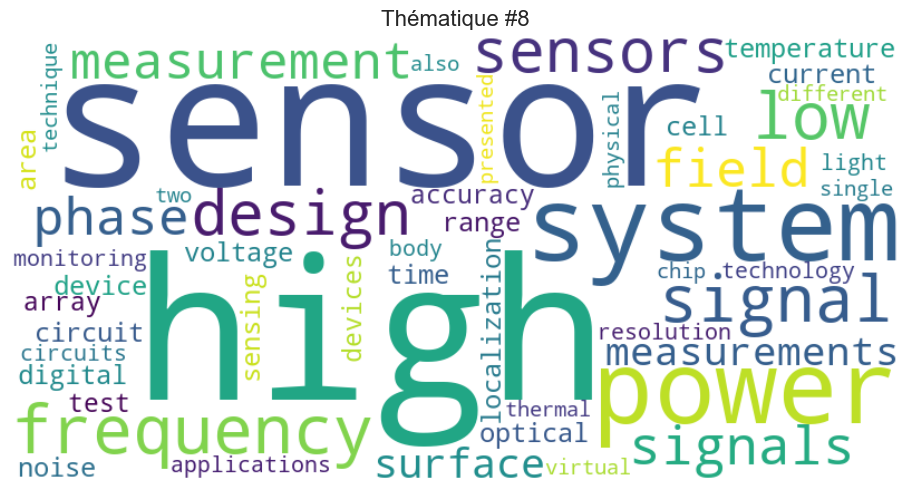

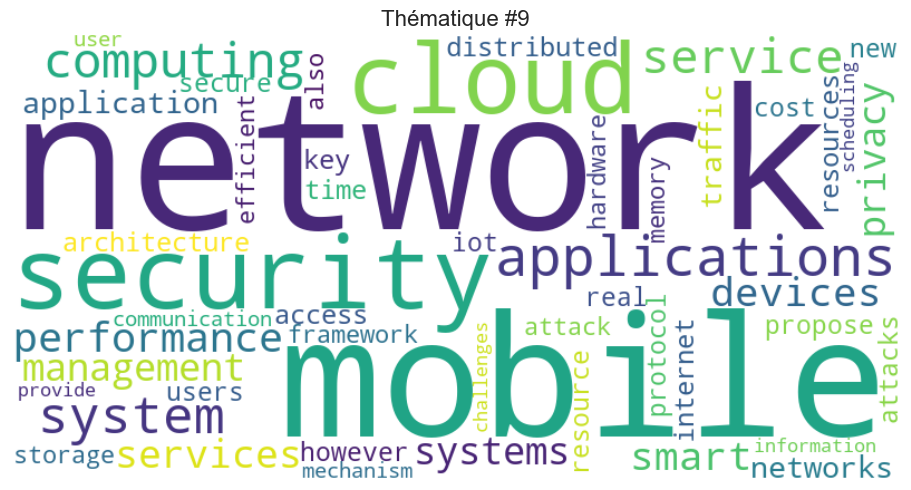

{0: <wordcloud.wordcloud.WordCloud at 0x229903b7980>,
 1: <wordcloud.wordcloud.WordCloud at 0x229904fd760>,
 2: <wordcloud.wordcloud.WordCloud at 0x22982d0ae40>,
 3: <wordcloud.wordcloud.WordCloud at 0x2298cb0b6b0>,
 4: <wordcloud.wordcloud.WordCloud at 0x22981589b80>,
 5: <wordcloud.wordcloud.WordCloud at 0x22991329400>,
 6: <wordcloud.wordcloud.WordCloud at 0x2299045ec00>,
 7: <wordcloud.wordcloud.WordCloud at 0x229904ff7d0>,
 8: <wordcloud.wordcloud.WordCloud at 0x2298ca8a300>,
 9: <wordcloud.wordcloud.WordCloud at 0x229815fbda0>}

In [5]:
# Visualisation des thématiques LDA
lda_viz = LDAVisualizer(df)
lda_model = lda_viz.fit_lda_model(num_topics=10, passes=10)
lda_viz.print_topics()
pyldavis_viz = lda_viz.visualize_lda_with_pyldavis()
lda_viz.plot_topic_distribution()
lda_viz.plot_document_topic_heatmap(n_docs=30)
lda_viz.create_topic_wordclouds()

## Interface interactive pour l'exploration

In [6]:
# Interface interactive pour l'exploration
# Recherche de la colonne de cluster
cluster_column = None
for col in df.columns:
    if 'cluster' in col:
        cluster_column = col
        break
        
explorer = InteractiveExplorer(
    df, 
    cluster_column=cluster_column,
    lda_model=lda_viz.lda_model,
    doc_topic_matrix=lda_viz.doc_topic_matrix
)
explorer.create_interactive_explorer()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>